# Table of Contents
<a id="table-of-contents"></a>
* [1. Introduction](#1)
* [2. General](#2)
    * [2.1. Numbers of rows and columns](#2.1)
    * [2.2. Numbers of missing values](#2.2)
    * [2.3. First 5 rows](#2.3)
    * [2.4. Basic statistics on continuous features](#2.4)
    * [2.5. Count on categorical features](#2.5)
    * [2.6. Target variables](#2.6)
* [3. Features & Target Relation](#3)
    * [3.1. Continuous features](#3.1)
    * [3.2. Categorical features](#3.2)
* [4. Baseline Model](#4)
    * [4.1 Preparation](#4.1)
    * [4.2 Catboost baseline model](#4.2)
    * [4.3 XGBoost baseline model](#4.3)
    * [4.4 LGBM baseline model](#4.4)
    * [4.5 Average baseline model](#4.5)
* [5. Tuned Model](#5)
    * [5.1 Catboost tuned model](#5.1)
    * [5.2 XGBoost tuned model](#5.2)
    * [5.3 LGBM tuned model](#5.3)
    * [5.4 Average tuned model](#5.4)
* [6. Winners Solutions](#6)

[back to top](#table-of-contents)
<a id="1"></a>
# 1. Introduction

Kaggle competitions are incredibly fun and rewarding, but they can also be intimidating for people who are relatively new in their data science journey. In the past, Kaggle have launched many Playground competitions that are more approachable than Featured competition, and thus more beginner-friendly.

The goal of these competitions is to provide a fun, but less challenging, tabular dataset. These competitions will be great for people looking for something in between the Titanic Getting Started competition and a Featured competition.

The dataset is used for this competition is synthetic but based on a real dataset and generated using a CTGAN. The original dataset deals with predicting the amount of an insurance claim. Although the features are anonymized, they have properties relating to real-world features.

[back to top](#table-of-contents)
<a id="2"></a>
# 2. General

**Observations:**

* `Train` set has 300,000 rows while `test` set has 200,000 rows.
* There are 19 categorical features from `cat0` - `cat18` and 11 continuous features from `cont0` - `cont10` with total of 30 features.
* There is no missing values in the train and test dataset.
* `Continuous` features on train anda test dataset ranging from -0.03 to 1 which are a multimodal distribution and similar between train and test dataset.
* Correlation between `continuous` features:
    * `cont1` has the highest correlation with `cont2` with a correlation of 0.9.
    * `cont10` has a high correlation of 0.8 with `cont0` and `cont7`.
    * `Continuous` features that have a correlation of 0.7 are:
        * between `cont0` and `cont7`
        * between `cont8` with `cont1`
        * between `cont8` with `cont2`
* `Category` features in `train` and `test` are similar at each others. Below are category features that have more than 50 categories:  
    * `cat5` has 84 categories mostly from `BI` category which has propotion around 79% followed by `AB` that has propotion around 14%.
    * `cat7` has 51 categories with `AH`, `E` and `AS` are the top 3 categories which have propotion around 15%, 13% and 8% respectively. Total propotion on top 20 categories is around 87%.
    * `cat8` has 61 categories with `BM`, `AE` and `AX` are the top 3 categories which have propotion of 14.1%, 8.1% and 7.4% respectively. Total propotion on top 20 categories is also around 87% same as `cat7`.
    * `cat10` has 299 categories with `DJ`, `HK` and `DP` are the top 3 categories which have propotion of 10.5%, 10.3% and 7.9% respectively. Total propotion on top 20 categories is also around 73%.
* Categories on `cat10` are different between `train` and `test` where `train` has 299 categories and `test` has 295 categories, this can be found on category `BS`, `JF`, `CH`, `MW`, `AW`, `FW`, `MO`, `MK`, `IL`, `GH`, `CX`, `LK` which are not found in `test` and there are `KM`, `BW`, `EJ`, `BU`, `CA`, `JM`, `DG`, `KE` which can not be found in `train`.
* There is an imbalance data on `target` variable where target variable: `0` is 73.5% while target variable: `1` is 26.5%. This should be treated carefully especially when creating cross validation.

In [1]:
import os
import joblib
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
train_df = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/train.csv')
test_df = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/test.csv')

In [3]:
cat_features = [feature for feature in train_df.columns if 'cat' in feature]
cont_features = [feature for feature in train_df.columns if 'cont' in feature]

[back to top](#table-of-contents)
<a id="2.1"></a>
## 2.1. Numbers of rows and columns

In [4]:
print('Rows and Columns in train dataset:', train_df.shape)
print('Rows and Columns in test dataset:', test_df.shape)

Rows and Columns in train dataset: (300000, 32)
Rows and Columns in test dataset: (200000, 31)


[back to top](#table-of-contents)
<a id="2.2"></a>
## 2.2. Numbers of missing values

In [5]:
print('Missing values in train dataset:', sum(train_df.isnull().sum()))
print('Missing values in test dataset:', sum(test_df.isnull().sum()))

Missing values in train dataset: 0
Missing values in test dataset: 0


[back to top](#table-of-contents)
<a id="2.3"></a>
## 2.3. First 5 rows

**First 5 rows in the train dataset**

In [6]:
train_df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,A,I,A,B,B,BI,A,S,Q,A,LO,A,A,A,A,B,D,D,B,0.629858,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,A,I,A,A,E,BI,K,W,AD,F,HJ,A,B,A,B,D,B,D,B,0.370727,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,A,K,A,A,E,BI,A,E,BM,L,DJ,A,B,A,A,B,D,D,B,0.502272,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,A,K,A,C,E,BI,A,Y,AD,F,KV,A,A,A,A,B,D,D,B,0.934242,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,A,I,G,B,E,BI,C,G,Q,A,DP,A,A,A,B,B,B,D,B,0.254427,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


**First 5 rows in the test dataset**

In [7]:
test_df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
0,5,A,F,A,A,F,BI,A,AH,AX,A,LF,A,A,A,A,B,D,D,B,0.708120,0.735690,0.578366,0.723154,0.228037,0.356227,0.551249,0.655693,0.598331,0.359987,0.947489
1,6,A,H,C,A,E,AB,I,F,N,A,MC,A,A,A,B,D,B,D,B,0.611637,0.313703,0.928885,0.516602,0.600169,0.795224,0.248987,0.654614,0.347944,0.565520,0.388580
2,8,A,N,C,A,F,AB,A,AH,BC,A,FN,A,A,A,B,B,D,D,B,0.456289,0.448201,0.424876,0.344729,0.242073,0.270632,0.746740,0.335590,0.341238,0.252289,0.411592
3,9,B,L,C,A,F,BI,A,E,AX,A,HK,A,A,A,A,B,D,B,B,0.338692,0.666092,0.598943,0.561971,0.806347,0.735983,0.538724,0.381566,0.481660,0.348514,0.325723
4,11,A,F,A,B,F,BI,A,AH,I,A,HX,A,A,A,A,D,D,D,B,0.631671,0.772229,0.479572,0.767745,0.252454,0.354810,0.178920,0.763479,0.562491,0.466261,0.585781


[back to top](#table-of-contents)
<a id="2.4"></a>
## 2.4. Basic statistics on continuous features
**Train dataset**

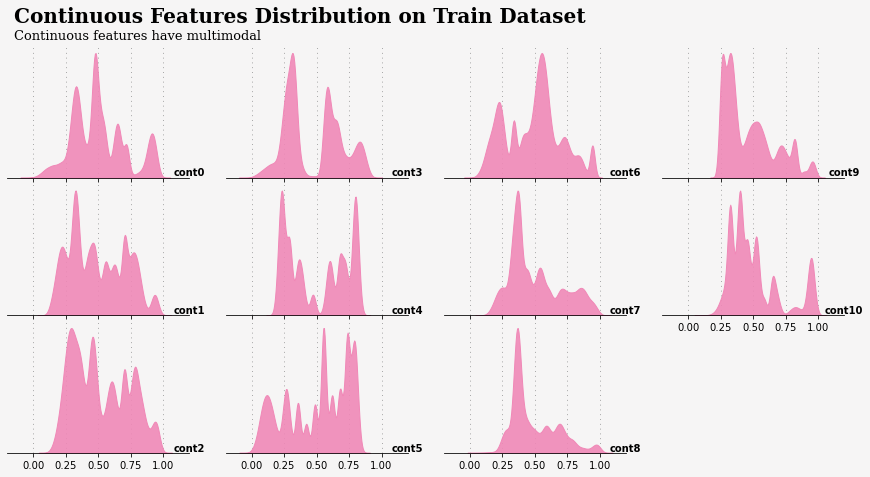

In [8]:
fig = plt.figure(figsize=(15, 10), facecolor='#f6f5f5')
gs = fig.add_gridspec(4, 4)
gs.update(wspace=0.2, hspace=0.05)

background_color = "#f6f5f5"

run_no = 0
for col in range(0, 4):
    for row in range(0, 3):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        locals()["ax"+str(run_no)].set_yticklabels([])
        locals()["ax"+str(run_no)].tick_params(axis='y', which=u'both',length=0)
        for s in ["top","right", 'left']:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

ax0.text(-0.15, 4.5, 'Continuous Features Distribution on Train Dataset', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-0.15, 4, 'Continuous features have multimodal', fontsize=13, fontweight='light', fontfamily='serif')        

run_no = 0
for col in cont_features:
    sns.kdeplot(train_df[col], ax=locals()["ax"+str(run_no)], shade=True, color='#f088b7', alpha=0.9, zorder=2)
    locals()["ax"+str(run_no)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
    locals()["ax"+str(run_no)].set_ylabel(col, fontsize=10, fontweight='bold').set_rotation(0)
    locals()["ax"+str(run_no)].yaxis.set_label_coords(1, 0)
    locals()["ax"+str(run_no)].set_xlim(-0.2, 1.2)
    locals()["ax"+str(run_no)].set_xlabel('')
    run_no += 1
    
ax11.remove()

In [9]:
train_df[cont_features].describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.504749,0.494073,0.516632,0.474235,0.504848,0.502257,0.488229,0.501739,0.488074,0.469496,0.508230
std,0.206788,0.213037,0.214851,0.216636,0.227474,0.241243,0.211335,0.203496,0.179048,0.194516,0.203393
min,-0.049562,0.084480,0.094493,-0.045316,0.168071,-0.036379,0.005199,0.090901,0.024139,0.214866,0.097789
25%,0.344985,0.317363,0.326047,0.292249,0.279303,0.276442,0.323914,0.353054,0.358915,0.309934,0.368312
50%,0.479650,0.463170,0.471247,0.387564,0.479858,0.554768,0.518089,0.435404,0.410908,0.407477,0.446576
75%,0.637657,0.693992,0.704625,0.644950,0.725779,0.735225,0.608537,0.642023,0.612725,0.586793,0.581957
max,1.004559,1.009958,1.016600,0.952187,0.858578,0.853022,0.966553,1.035818,1.055885,1.005652,1.011331


**Test dataset**

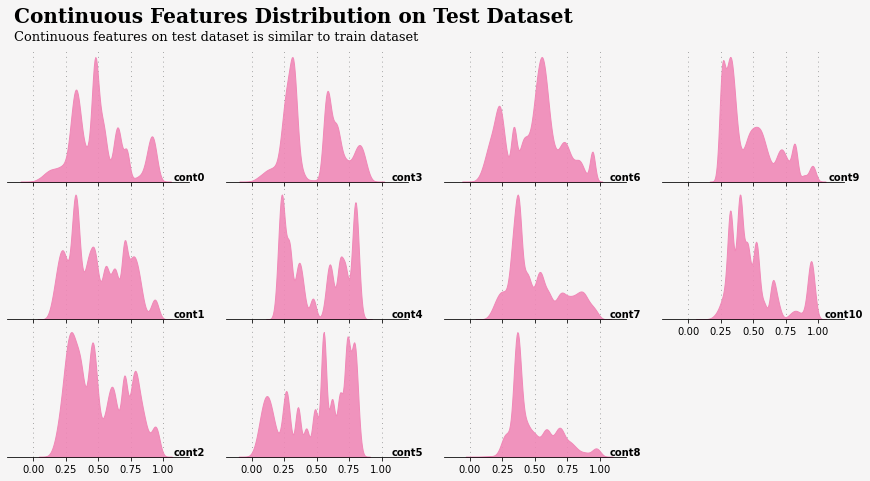

In [10]:
fig = plt.figure(figsize=(15, 10), facecolor='#f6f5f5')
gs = fig.add_gridspec(4, 4)
gs.update(wspace=0.2, hspace=0.05)

background_color = "#f6f5f5"

run_no = 0
for col in range(0, 4):
    for row in range(0, 3):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        locals()["ax"+str(run_no)].set_yticklabels([])
        locals()["ax"+str(run_no)].tick_params(axis='y', which=u'both',length=0)
        for s in ["top","right", 'left']:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

ax0.text(-0.15, 4.5, 'Continuous Features Distribution on Test Dataset', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-0.15, 4, 'Continuous features on test dataset is similar to train dataset', fontsize=13, fontweight='light', fontfamily='serif')        

run_no = 0
for col in cont_features:
    sns.kdeplot(test_df[col], ax=locals()["ax"+str(run_no)], shade=True, color='#f088b7', alpha=0.9, zorder=2)
    locals()["ax"+str(run_no)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
    locals()["ax"+str(run_no)].set_ylabel(col, fontsize=10, fontweight='bold').set_rotation(0)
    locals()["ax"+str(run_no)].yaxis.set_label_coords(1, 0)
    locals()["ax"+str(run_no)].set_xlim(-0.2, 1.2)
    locals()["ax"+str(run_no)].set_xlabel('')
    run_no += 1
    
ax11.remove()

In [11]:
test_df[cont_features].describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.505388,0.493960,0.516425,0.475286,0.504772,0.501180,0.487315,0.502684,0.488331,0.469813,0.508974
std,0.207417,0.212695,0.214752,0.216919,0.227199,0.241375,0.211335,0.203793,0.178895,0.194999,0.203926
min,-0.044929,0.090478,0.098591,-0.038178,0.171321,-0.036337,-0.005648,0.096067,0.013554,0.215540,0.113059
25%,0.344748,0.317788,0.326210,0.292777,0.279413,0.275422,0.322365,0.353388,0.359121,0.309888,0.368999
50%,0.479633,0.463195,0.470893,0.392118,0.480299,0.554723,0.517318,0.436139,0.411318,0.407066,0.446578
75%,0.638773,0.693882,0.704745,0.645803,0.725272,0.735137,0.607454,0.646104,0.612508,0.588008,0.583082
max,1.006825,1.011597,1.012128,0.965609,0.867198,0.848617,0.964635,1.033760,1.053155,1.007189,1.007168


**Correlation between continuous variables**

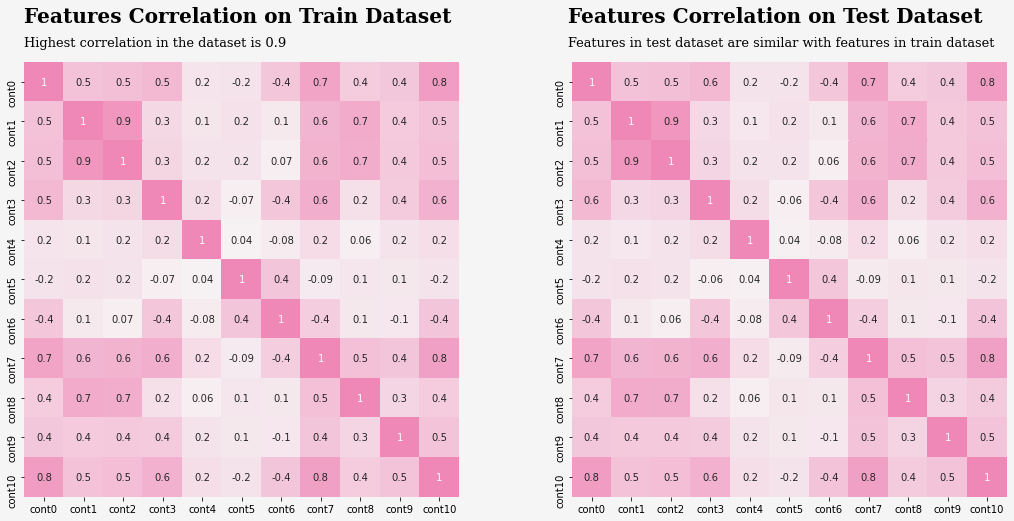

In [12]:
background_color = "#f6f5f5"

fig = plt.figure(figsize=(18, 8), facecolor=background_color)
gs = fig.add_gridspec(1, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
colors = ["#f088b7", "#f6f5f5","#f088b7"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

ax0.set_facecolor(background_color)
ax0.text(0, -1, 'Features Correlation on Train Dataset', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(0, -0.4, 'Highest correlation in the dataset is 0.9', fontsize=13, fontweight='light', fontfamily='serif')

ax1.set_facecolor(background_color)
ax1.text(-0.1, -1, 'Features Correlation on Test Dataset', fontsize=20, fontweight='bold', fontfamily='serif')
ax1.text(-0.1, -0.4, 'Features in test dataset are similar with features in train dataset ', 
         fontsize=13, fontweight='light', fontfamily='serif')

sns.heatmap(train_df[cont_features].corr(), ax=ax0, vmin=-1, vmax=1, annot=True, square=True, 
            cbar_kws={"orientation": "horizontal"}, cbar=False, cmap=colormap, fmt='.1g')

sns.heatmap(test_df[cont_features].corr(), ax=ax1, vmin=-1, vmax=1, annot=True, square=True, 
            cbar_kws={"orientation": "horizontal"}, cbar=False, cmap=colormap, fmt='.1g')

plt.show()

[back to top](#table-of-contents)
<a id="2.5"></a>
## 2.5. Categorical features proportion
**Train dataset**

In [13]:
cat5_category = list(pd.DataFrame(train_df['cat5'].value_counts()/len(train_df['cat5'])*100)[:2].index)
cat7_category = list(pd.DataFrame(train_df['cat7'].value_counts()/len(train_df['cat7'])*100)[:13].index)
cat8_category = list(pd.DataFrame(train_df['cat8'].value_counts()/len(train_df['cat8'])*100)[:13].index)
cat10_category = list(pd.DataFrame(train_df['cat10'].value_counts()/len(train_df['cat10'])*100)[:13].index)
train_df['cat5'] = np.where(~train_df['cat5'].isin(cat5_category), 'Others', train_df['cat5'])
train_df['cat7'] = np.where(~train_df['cat7'].isin(cat7_category), 'Others', train_df['cat7'])
train_df['cat8'] = np.where(~train_df['cat8'].isin(cat8_category), 'Others', train_df['cat8'])
train_df['cat10'] = np.where(~train_df['cat10'].isin(cat10_category), 'Others', train_df['cat10'])

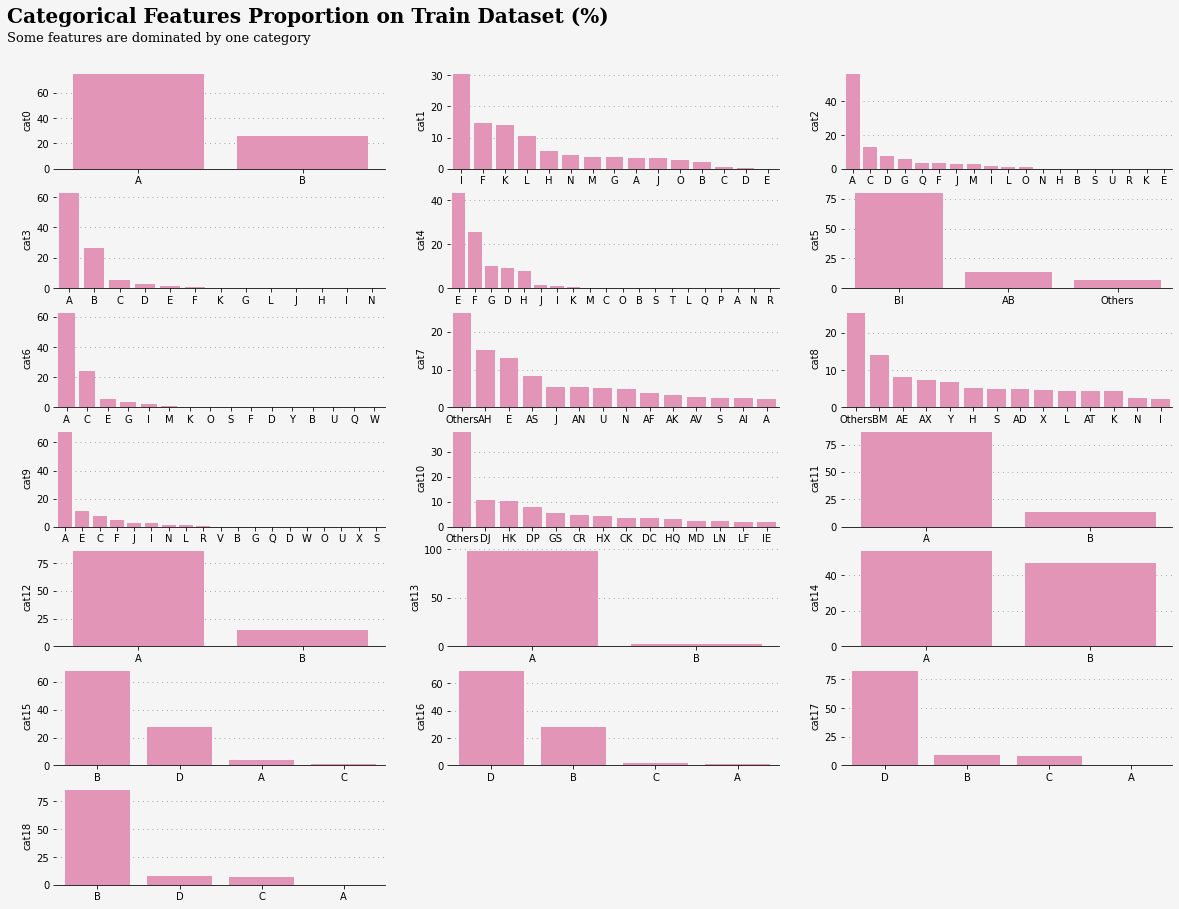

In [14]:
background_color = "#f6f5f5"

fig = plt.figure(figsize=(20, 15), facecolor=background_color)
gs = fig.add_gridspec(7, 3)
gs.update(wspace=0.2, hspace=0.2)

run_no = 0
for row in range(0, 7):
    for col in range(0, 3):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        for s in ["top","right", 'left']:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

ax0.text(-0.8, 115, 'Categorical Features Proportion on Train Dataset (%)', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-0.8, 100, 'Some features are dominated by one category', fontsize=13, fontweight='light', fontfamily='serif')        

run_no = 0
for col in cat_features:
    chart_df = pd.DataFrame(train_df[col].value_counts() / len(train_df) * 100)
    sns.barplot(x=chart_df.index, y=chart_df[col], ax=locals()["ax"+str(run_no)], color='#f088b7', zorder=2)
    locals()["ax"+str(run_no)].grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,5))
    run_no += 1
    
ax19.remove()
ax20.remove()

**Test dataset**

In [15]:
cat5_category = list(pd.DataFrame(test_df['cat5'].value_counts()/len(test_df['cat5'])*100)[:2].index)
cat7_category = list(pd.DataFrame(test_df['cat7'].value_counts()/len(test_df['cat7'])*100)[:13].index)
cat8_category = list(pd.DataFrame(test_df['cat8'].value_counts()/len(test_df['cat8'])*100)[:13].index)
cat10_category = list(pd.DataFrame(test_df['cat10'].value_counts()/len(test_df['cat10'])*100)[:13].index)
test_df['cat5'] = np.where(~test_df['cat5'].isin(cat5_category), 'Others', test_df['cat5'])
test_df['cat7'] = np.where(~test_df['cat7'].isin(cat7_category), 'Others', test_df['cat7'])
test_df['cat8'] = np.where(~test_df['cat8'].isin(cat8_category), 'Others', test_df['cat8'])
test_df['cat10'] = np.where(~test_df['cat10'].isin(cat10_category), 'Others', test_df['cat10'])

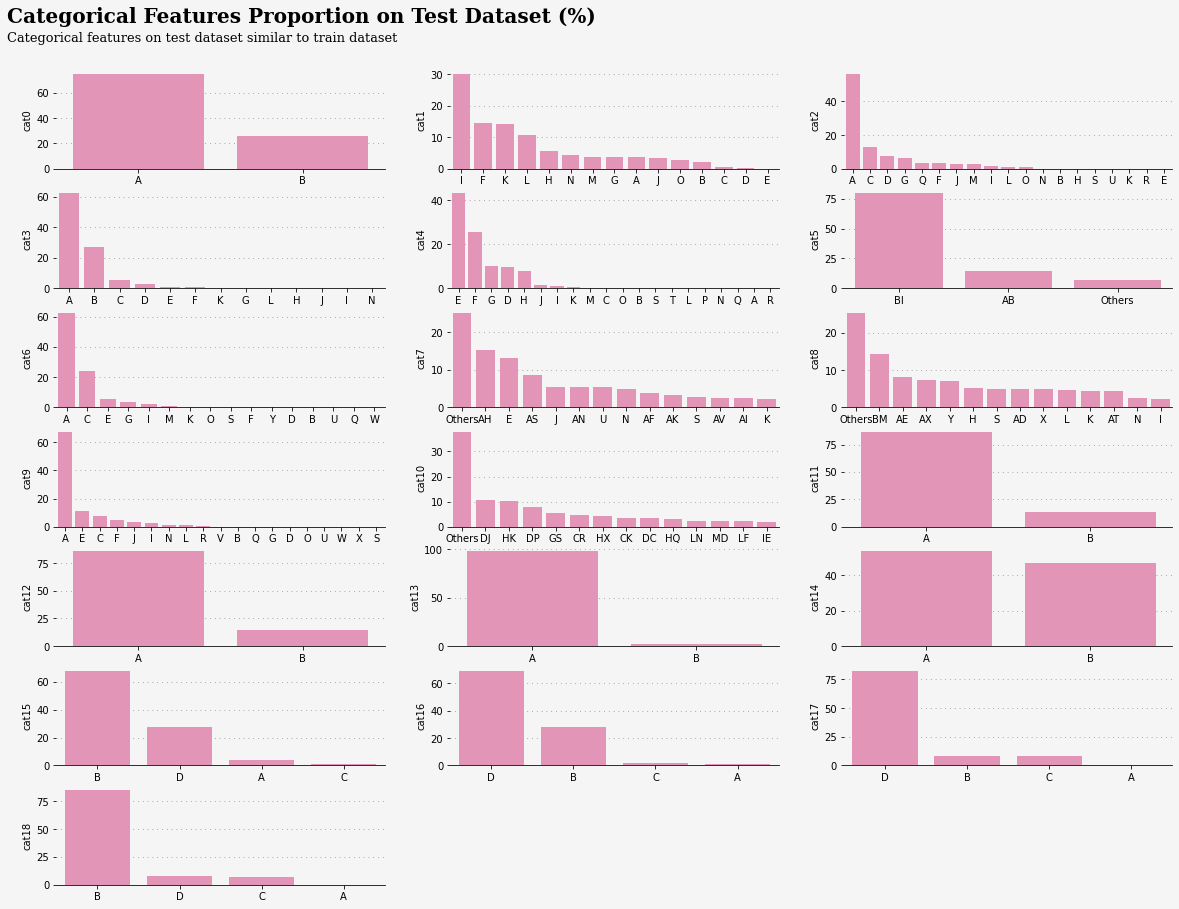

In [16]:
background_color = "#f6f5f5"

fig = plt.figure(figsize=(20, 15), facecolor=background_color)
gs = fig.add_gridspec(7, 3)
gs.update(wspace=0.2, hspace=0.2)

run_no = 0
for row in range(0, 7):
    for col in range(0, 3):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        for s in ["top","right", 'left']:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

ax0.text(-0.8, 115, 'Categorical Features Proportion on Test Dataset (%)', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-0.8, 100, 'Categorical features on test dataset similar to train dataset', 
         fontsize=13, fontweight='light', fontfamily='serif')        

run_no = 0
for col in cat_features:
    chart_df = pd.DataFrame(test_df[col].value_counts() / len(test_df) * 100)
    sns.barplot(x=chart_df.index, y=chart_df[col], ax=locals()["ax"+str(run_no)], color='#f088b7', zorder=2)
    locals()["ax"+str(run_no)].grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,5))
    run_no += 1
    
ax19.remove()
ax20.remove()

[back to top](#table-of-contents)
<a id="2.5"></a>
## 2.6. Target

In [17]:
# reset train and test dataset
train_df = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/train.csv')
test_df = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/test.csv')

print('Propotion of target variable: 0 is', len(train_df[train_df['target']==0])/len(train_df))
print('Propotion of target variable: 1 is', len(train_df[train_df['target']==1])/len(train_df))

Propotion of target variable: 0 is 0.73513
Propotion of target variable: 1 is 0.26487


[back to top](#table-of-contents)
<a id="3"></a>
# 3. Features & Target Relations

**Observations:**
* `Continuous` features:
    * Target variable: `0` is marked by color <span style='color:#facd00' > Yellow </span> while continuous features with target `1` marked by color <span style='color:#f088b7' > Pink </span>.
    * In general, there is no distinct distribution on `continuous` features between target `0` and target `1`.
* `Categorical` features:
    * `cat0`: `A`, `cat5`: `BI`, `cat6`: `A`, `cat9`: `A`, `cat11`: `A`, `cat12`: `A`, `cat13`: `A`, `cat14`: `A`, `cat15`: `B`, `cat16`: `D`, `cat17`: `D` and `cat18`: `B` are categories that have more than 40% target variable: `0` of total train dataset.
    * There is no category in `categorical` features that has target variable: `1` above 25% of total train dataset.

[back to top](#table-of-contents)
<a id="3.1"></a>
## 3.1 Continuous features

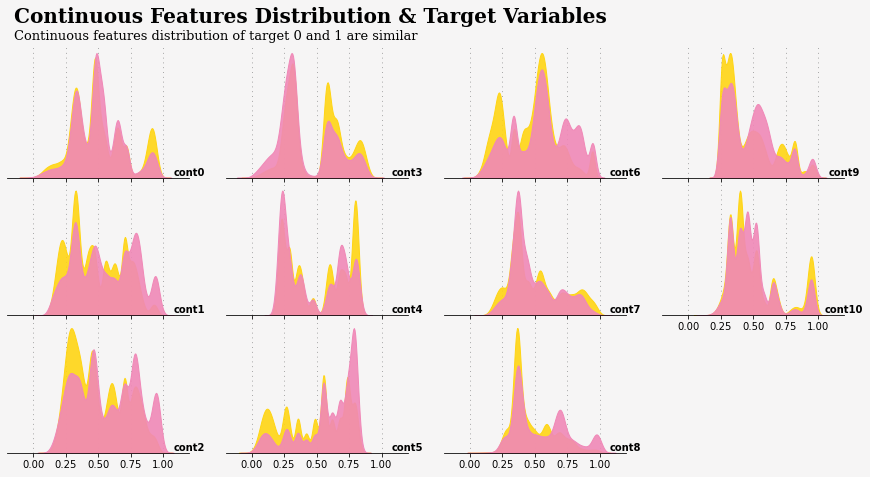

In [18]:
fig = plt.figure(figsize=(15, 10), facecolor='#f6f5f5')
gs = fig.add_gridspec(4, 4)
gs.update(wspace=0.2, hspace=0.05)

background_color = "#f6f5f5"

run_no = 0
for col in range(0, 4):
    for row in range(0, 3):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        locals()["ax"+str(run_no)].set_yticklabels([])
        locals()["ax"+str(run_no)].tick_params(axis='y', which=u'both',length=0)
        for s in ["top","right", 'left']:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

ax0.text(-0.15, 4.5, 'Continuous Features Distribution & Target Variables', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-0.15, 4, 'Continuous features distribution of target 0 and 1 are similar', fontsize=13, fontweight='light', fontfamily='serif')        

run_no = 0
for col in cont_features:
    sns.kdeplot(train_df.loc[train_df['target'] == 0, col], ax=locals()["ax"+str(run_no)], 
                shade=True, color='#ffd514', alpha=0.9, zorder=2)
    sns.kdeplot(train_df.loc[train_df['target'] == 1, col], ax=locals()["ax"+str(run_no)], 
                shade=True, color='#f088b7', alpha=0.9, zorder=2)
    locals()["ax"+str(run_no)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
    locals()["ax"+str(run_no)].set_ylabel(col, fontsize=10, fontweight='bold').set_rotation(0)
    locals()["ax"+str(run_no)].yaxis.set_label_coords(1, 0)
    locals()["ax"+str(run_no)].set_xlim(-0.2, 1.2)
    locals()["ax"+str(run_no)].set_xlabel('')
    run_no += 1
    
ax11.remove()

[back to top](#table-of-contents)
<a id="3.2"></a>
## 3.2 Categorical features
**Target: 0**

In [19]:
# reset train and test dataset
train_df = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/train.csv')
test_df = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/test.csv')

In [20]:
cat5_category = list(pd.DataFrame(train_df.loc[train_df['target']==0, 'cat5'].value_counts()/len(train_df['cat5'])*100)[:2].index)
cat7_category = list(pd.DataFrame(train_df.loc[train_df['target']==0, 'cat7'].value_counts()/len(train_df['cat7'])*100)[:13].index)
cat8_category = list(pd.DataFrame(train_df.loc[train_df['target']==0, 'cat8'].value_counts()/len(train_df['cat8'])*100)[:13].index)
cat10_category = list(pd.DataFrame(train_df.loc[train_df['target']==0, 'cat10'].value_counts()/len(train_df['cat10'])*100)[:13].index)
train_df['cat5'] = np.where(~train_df['cat5'].isin(cat5_category), 'Others', train_df['cat5'])
train_df['cat7'] = np.where(~train_df['cat7'].isin(cat7_category), 'Others', train_df['cat7'])
train_df['cat8'] = np.where(~train_df['cat8'].isin(cat8_category), 'Others', train_df['cat8'])
train_df['cat10'] = np.where(~train_df['cat10'].isin(cat10_category), 'Others', train_df['cat10'])

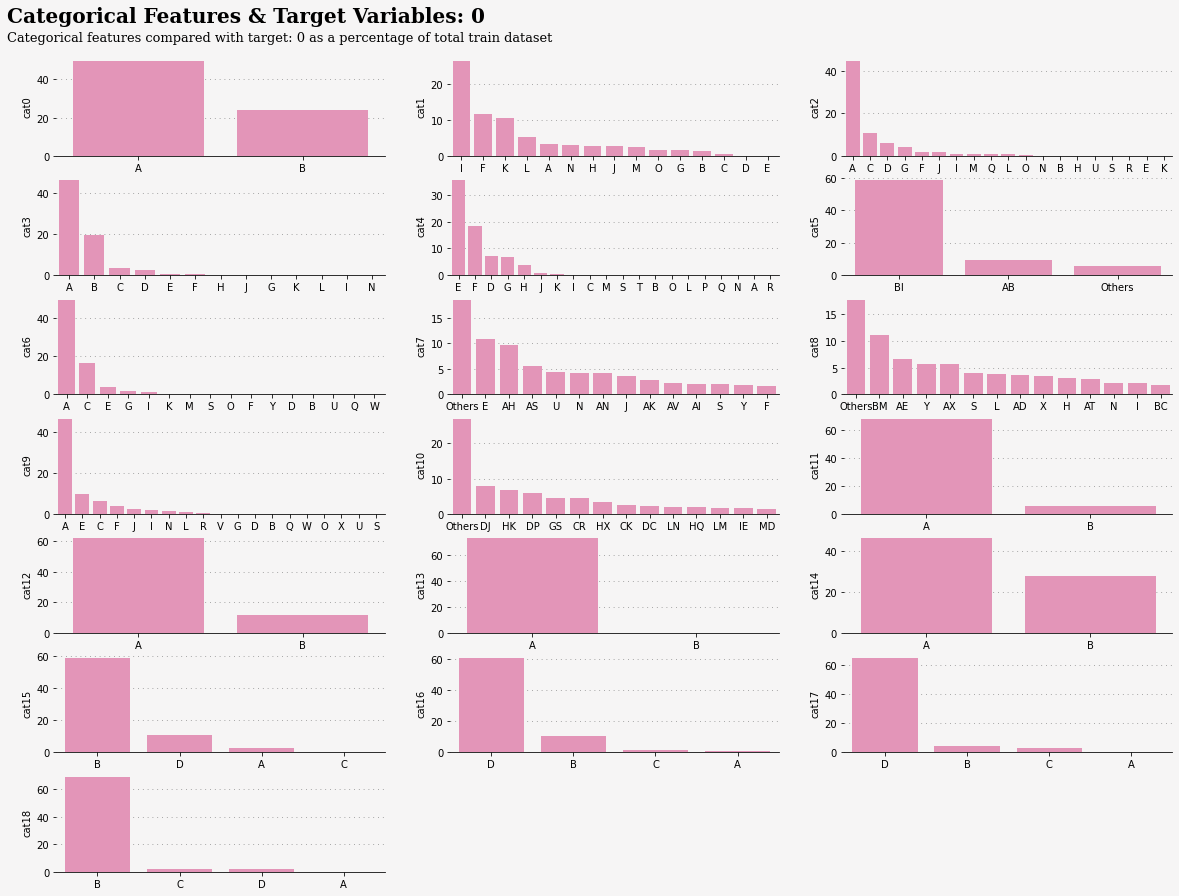

In [21]:
background_color = "#f6f5f5"

fig = plt.figure(figsize=(20, 15), facecolor=background_color)
gs = fig.add_gridspec(7, 3)
gs.update(wspace=0.2, hspace=0.2)

run_no = 0
for row in range(0, 7):
    for col in range(0, 3):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        for s in ["top","right", 'left']:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

ax0.text(-0.8, 70, 'Categorical Features & Target Variables: 0', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-0.8, 60, 'Categorical features compared with target: 0 as a percentage of total train dataset', 
         fontsize=13, fontweight='light', fontfamily='serif')        

run_no = 0
for col in cat_features:
    chart_df = pd.DataFrame(train_df.loc[train_df['target']==0, col].value_counts() / len(train_df) * 100)
    sns.barplot(x=chart_df.index, y=chart_df[col], ax=locals()["ax"+str(run_no)], color='#f088b7', zorder=2)
    locals()["ax"+str(run_no)].grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,5))
    run_no += 1
    
ax19.remove()
ax20.remove()

**Target: 1**

In [22]:
cat5_category = list(pd.DataFrame(train_df.loc[train_df['target']==1, 'cat5'].value_counts()/len(train_df['cat5'])*100)[:2].index)
cat7_category = list(pd.DataFrame(train_df.loc[train_df['target']==1, 'cat7'].value_counts()/len(train_df['cat7'])*100)[:13].index)
cat8_category = list(pd.DataFrame(train_df.loc[train_df['target']==1, 'cat8'].value_counts()/len(train_df['cat8'])*100)[:13].index)
cat10_category = list(pd.DataFrame(train_df.loc[train_df['target']==1, 'cat10'].value_counts()/len(train_df['cat10'])*100)[:13].index)
train_df['cat5'] = np.where(~train_df['cat5'].isin(cat5_category), 'Others', train_df['cat5'])
train_df['cat7'] = np.where(~train_df['cat7'].isin(cat7_category), 'Others', train_df['cat7'])
train_df['cat8'] = np.where(~train_df['cat8'].isin(cat8_category), 'Others', train_df['cat8'])
train_df['cat10'] = np.where(~train_df['cat10'].isin(cat10_category), 'Others', train_df['cat10'])

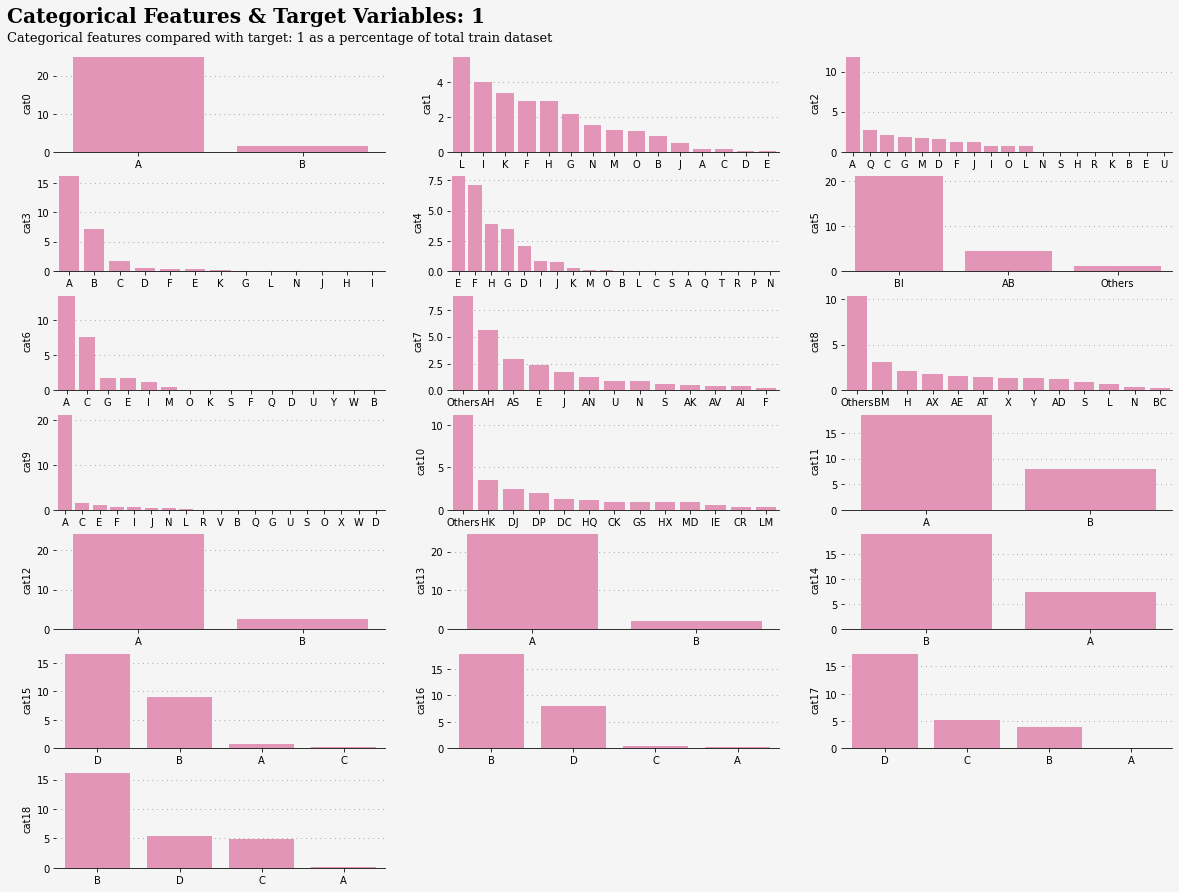

In [23]:
background_color = "#f6f5f5"

fig = plt.figure(figsize=(20, 15), facecolor=background_color)
gs = fig.add_gridspec(7, 3)
gs.update(wspace=0.2, hspace=0.2)

run_no = 0
for row in range(0, 7):
    for col in range(0, 3):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        for s in ["top","right", 'left']:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

ax0.text(-0.8, 34, 'Categorical Features & Target Variables: 1', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-0.8, 29
         , 'Categorical features compared with target: 1 as a percentage of total train dataset', 
         fontsize=13, fontweight='light', fontfamily='serif')        

run_no = 0
for col in cat_features:
    chart_df = pd.DataFrame(train_df.loc[train_df['target']==1, col].value_counts() / len(train_df) * 100)
    sns.barplot(x=chart_df.index, y=chart_df[col], ax=locals()["ax"+str(run_no)], color='#f088b7', zorder=2)
    locals()["ax"+str(run_no)].grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,5))
    run_no += 1
    
ax19.remove()
ax20.remove()

[back to top](#table-of-contents)
<a id="4"></a>
# 4. Baseline Model

This section will evaluate the performance of `Catboost`, `XGBoost` and `LGBM` using 3 dataset `all features`, `categorical features only` and `continuous features only`.. At the end, `Voting Classifiers` will be used to ensemble all of the model.

**Observations:**
* `LGBM` has the highest AUC of `0.89156` for using `all features` and `categorical features only` dataset but the results is close with `XGBoost` and `Catboost`.
* `XGBoost` performs the best on `continuous features only` dataset with AUC of `0.88412` and again the result is close with other model.
* Ensembling the 3 models by averaging them beats the individual baseline model with OOF AUC of `0.89360` for `all features`, `0.89017` for `categorical features only` and `0.86194` for `continuous features only`.

[back to top](#table-of-contents)
<a id="4.1"></a>
## 4.1 Preparation

**Steps:**
1. Load `packages` for performing label encoding, cross validation, modeling and AUC measurement.
2. Combine `train` and `test` dataset, the purpose is to tackle missing categories on `train` and `test` when performing label encoding.
3. Label encode all the `categorical` features.
4. Split back `combine` dataset that has been label encoded into `train` and `test` dataset.

In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score

In [25]:
train_df = pd.read_csv('../input/tabular-playground-series-mar-2021/train.csv')
test_df = pd.read_csv('../input/tabular-playground-series-mar-2021/test.csv')
combine_df = pd.concat([train_df, test_df], axis=0)
average_all_df = pd.DataFrame()
average_cat_df = pd.DataFrame()
average_cont_df = pd.DataFrame()

le = LabelEncoder()
for col in cat_features:
    combine_df[col] = le.fit_transform(combine_df[col])
train_df = combine_df.iloc[:len(train_df), :]
test_df = combine_df.iloc[len(train_df):, :]
test_df = test_df.drop('target', axis=1)

folds = 10
kf = KFold(n_splits=folds, shuffle=True, random_state=42)

features = [feature for feature in train_df.columns if feature not in ['id', 'target']]

[back to top](#table-of-contents)
<a id="4.2"></a>
## 4.2 Catboost baseline model

`CatBosstClassifier` is used for the baseline model in this notebooks without hyperparameters tuning using 10 fold cross validation. 

**Observations**:
* Using `all features` still resulting the best AUC compared to use `categorical` or `continuous` features only.
* The AUC gap between `continuous features only` and `categorical features only` is big.
* Below are the OOF AUC results:
    * `all features` resulting a `0.88977` OOF AUC.
    * `categorical features only` resulting a `0.88512` OOF AUC.
    * `continuous features only` resulting a `0.81459` OOF AUC.


**Note:** Remove `task_type="GPU"` and `devices="0"` to use CPU only.

**Using all features**

In [26]:
train_oof = np.zeros((300000,))

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df[features], train_df['target'])):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
    
    X_train = train[features]
    X_valid = valid[features]
    y_train = train['target']
    y_valid = valid['target']

    model = CatBoostClassifier(verbose=0,
                                eval_metric="AUC",
                                random_state=42,
                                cat_features=[x for x in range(len(cat_features))],
                                task_type="GPU",
                                devices="0")

    model =  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    temp_oof = model.predict_proba(X_valid)[:,1]
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} AUC: ', roc_auc_score(y_valid, temp_oof))
    
print(f'OOF AUC - All features: ', roc_auc_score(train_df['target'], train_oof))
average_all_df['catboost'] = train_oof 

Fold 0 AUC:  0.8878825876709235
Fold 1 AUC:  0.8918379729255149
Fold 2 AUC:  0.8930825916398644
Fold 3 AUC:  0.8922295197729384
Fold 4 AUC:  0.8862036881692582
Fold 5 AUC:  0.8873021731053294
Fold 6 AUC:  0.8876806428473484
Fold 7 AUC:  0.8899747868434585
Fold 8 AUC:  0.8910013712215257
Fold 9 AUC:  0.8908745141409036
OOF AUC - All features:  0.8897921157300137


**Using categorical features only**

In [27]:
train_oof = np.zeros((300000,))

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df[features], train_df['target'])):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
    
    X_train = train[cat_features]
    X_valid = valid[cat_features]
    y_train = train['target']
    y_valid = valid['target']

    model = CatBoostClassifier(verbose=0,
                                eval_metric="AUC",
                                random_state=42,
                                cat_features=[x for x in range(len(cat_features))],
                                task_type="GPU",
                                devices="0")

    model =  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    temp_oof = model.predict_proba(X_valid)[:,1]
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} AUC: ', roc_auc_score(y_valid, temp_oof))
    
print(f'OOF AUC - Categorical features only: ', roc_auc_score(train_df['target'], train_oof))
average_cat_df['catboost'] = train_oof 

Fold 0 AUC:  0.8825865442487905
Fold 1 AUC:  0.8874518350808054
Fold 2 AUC:  0.8880659662979354
Fold 3 AUC:  0.8878954956236176
Fold 4 AUC:  0.8811783488834485
Fold 5 AUC:  0.8823585482197392
Fold 6 AUC:  0.8836316504897839
Fold 7 AUC:  0.885763946706637
Fold 8 AUC:  0.886580291076759
Fold 9 AUC:  0.8858024451237229
OOF AUC - Categorical features only:  0.8851170304090602


**Using continuous features only**

In [28]:
train_oof = np.zeros((300000,))

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df[features], train_df['target'])):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
    
    X_train = train[cont_features]
    X_valid = valid[cont_features]
    y_train = train['target']
    y_valid = valid['target']

    model = CatBoostClassifier(verbose=0,
                                eval_metric="AUC",
                                random_state=42,
                                task_type="GPU",
                                devices="0")

    model =  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    temp_oof = model.predict_proba(X_valid)[:,1]
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} AUC: ', roc_auc_score(y_valid, temp_oof))
    
print(f'OOF AUC - Continuous features only: ', roc_auc_score(train_df['target'], train_oof))
average_cont_df['catboost'] = train_oof 

Fold 0 AUC:  0.8155675211980387
Fold 1 AUC:  0.8162867562400608
Fold 2 AUC:  0.8172552672584235
Fold 3 AUC:  0.8144927708401747
Fold 4 AUC:  0.8133634436848559
Fold 5 AUC:  0.8113691050666523
Fold 6 AUC:  0.813943829584787
Fold 7 AUC:  0.8141520909100339
Fold 8 AUC:  0.8143583600641398
Fold 9 AUC:  0.8154661660591648
OOF AUC - Continuous features only:  0.8146142989522547


[back to top](#table-of-contents)
<a id="4.2"></a>
## 4.3 XGBoost baseline model

`XGBClassifier` is used for the baseline model in this notebooks without hyperparameters tuning using 10 fold cross validation. 

**Observations**:
* Using `all features` still resulting the best AUC compared to use `categorical` or `continuous` features only.
* The AUC gap between `continuous features only` and `categorical features only` is big.
* Below are the OOF AUC results:
    * `all features` resulting a `0.88986` OOF AUC.
    * `categorical features only` resulting a `0.88412` OOF AUC.
    * `continuous features only` resulting a `0.81767` OOF AUC.


**Note:** Remove `tree_method="gpu_hist"` and `gpu_id="0"` to use CPU only.

**Using all features**

In [29]:
train_oof = np.zeros((300000,))

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df[features], train_df['target'])):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
    
    X_train = train[features]
    X_valid = valid[features]
    y_train = train['target']
    y_valid = valid['target']

    model = XGBClassifier(eval_metric="auc",
                          random_state=42,
                          tree_method="gpu_hist",
                          gpu_id="0",
                          use_label_encoder=False,)

    model =  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
    temp_oof = model.predict_proba(X_valid)[:,1]
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} AUC: ', roc_auc_score(y_valid, temp_oof))
    
print(f'OOF AUC - All features: ', roc_auc_score(train_df['target'], train_oof))
average_all_df['xgboost'] = train_oof 

Fold 0 AUC:  0.889144911652152
Fold 1 AUC:  0.8923516887523135
Fold 2 AUC:  0.8923835002620305
Fold 3 AUC:  0.8921719958677461
Fold 4 AUC:  0.8876002458218543
Fold 5 AUC:  0.8867911863723278
Fold 6 AUC:  0.8871504227608885
Fold 7 AUC:  0.8893557109867152
Fold 8 AUC:  0.8922132479887871
Fold 9 AUC:  0.8896213335069109
OOF AUC - All features:  0.8898682759959127


**Using categorical features only**

In [30]:
train_oof = np.zeros((300000,))

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df[features], train_df['target'])):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
    
    X_train = train[cat_features]
    X_valid = valid[cat_features]
    y_train = train['target']
    y_valid = valid['target']

    model = XGBClassifier(eval_metric="auc",
                          random_state=42,
                          tree_method="gpu_hist",
                          gpu_id="0",
                          use_label_encoder=False,)

    model =  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
    temp_oof = model.predict_proba(X_valid)[:,1]
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} AUC: ', roc_auc_score(y_valid, temp_oof))
    
print(f'OOF AUC - Categorical features only: ', roc_auc_score(train_df['target'], train_oof))
average_cat_df['xgboost'] = train_oof 

Fold 0 AUC:  0.882167737436796
Fold 1 AUC:  0.8870120866750187
Fold 2 AUC:  0.8869399318856828
Fold 3 AUC:  0.8871556957021203
Fold 4 AUC:  0.8799225286086372
Fold 5 AUC:  0.8808077497304008
Fold 6 AUC:  0.8814713409671406
Fold 7 AUC:  0.8854542297297546
Fold 8 AUC:  0.886203228698093
Fold 9 AUC:  0.884386323992111
OOF AUC - Categorical features only:  0.8841241471177758


**Using continuous features only**

In [31]:
train_oof = np.zeros((300000,))

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df[features], train_df['target'])):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
    
    X_train = train[cont_features]
    X_valid = valid[cont_features]
    y_train = train['target']
    y_valid = valid['target']

    model = XGBClassifier(eval_metric="auc",
                          random_state=42,
                          tree_method="gpu_hist",
                          gpu_id="0",
                          use_label_encoder=False,)

    model =  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
    temp_oof = model.predict_proba(X_valid)[:,1]
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} AUC: ', roc_auc_score(y_valid, temp_oof))
    
print(f'OOF AUC - Continuous features only: ', roc_auc_score(train_df['target'], train_oof))
average_cont_df['xgboost'] = train_oof 

Fold 0 AUC:  0.81755980101638
Fold 1 AUC:  0.8217324901110581
Fold 2 AUC:  0.8199633359282164
Fold 3 AUC:  0.8171733489781514
Fold 4 AUC:  0.815861838029643
Fold 5 AUC:  0.8140826604681511
Fold 6 AUC:  0.8164873337012936
Fold 7 AUC:  0.8164716473130859
Fold 8 AUC:  0.8194644574558227
Fold 9 AUC:  0.8179982758273254
OOF AUC - Continuous features only:  0.8176781093347958


[back to top](#table-of-contents)
<a id="4.4"></a>
## 4.4 LGBM baseline model

`XGBClassifier` is used for the baseline model in this notebooks without hyperparameters tuning using 10 fold cross validation. 

**Observations**:
* Using `all features` still resulting the best AUC compared to use `categorical` or `continuous` features only.
* The AUC gap between `continuous features only` and `categorical features only` is big.
* Below are the OOF AUC results:
    * `all features` resulting a `0.89156` OOF AUC.
    * `categorical features only` resulting a `0.88602` OOF AUC.
    * `continuous features only` resulting a `0.81028` OOF AUC.


**Note:** Remove `device='gpu'` to use CPU only.

**Using all features**

In [32]:
train_oof = np.zeros((300000,))

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df[features], train_df['target'])):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
    
    X_train = train[features]
    X_valid = valid[features]
    y_train = train['target']
    y_valid = valid['target']

    model = LGBMClassifier(metric="auc",
                          random_state=42,
                          cat_feature=[x for x in range(len(cat_features))],
                          device='gpu')

    model =  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
    temp_oof = model.predict_proba(X_valid)[:,1]
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} AUC: ', roc_auc_score(y_valid, temp_oof))
    
print(f'OOF AUC - All features: ', roc_auc_score(train_df['target'], train_oof))
average_all_df['lgbm'] = train_oof 

Fold 0 AUC:  0.8900937872722371
Fold 1 AUC:  0.8940496307223005
Fold 2 AUC:  0.8951618659288048
Fold 3 AUC:  0.8941779617746212
Fold 4 AUC:  0.8880874739395967
Fold 5 AUC:  0.8888124779109914
Fold 6 AUC:  0.8893553821570123
Fold 7 AUC:  0.8913392814385384
Fold 8 AUC:  0.8931747181049038
Fold 9 AUC:  0.891566772843746
OOF AUC - All features:  0.891568125483658


**Using categorical features only**

In [33]:
train_oof = np.zeros((300000,))

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df[features], train_df['target'])):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
    
    X_train = train[cat_features]
    X_valid = valid[cat_features]
    y_train = train['target']
    y_valid = valid['target']

    model = LGBMClassifier(metric="auc",
                          random_state=42,
                          cat_feature=[x for x in range(len(cat_features))],
                          device='gpu')

    model =  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
    temp_oof = model.predict_proba(X_valid)[:,1]
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} AUC: ', roc_auc_score(y_valid, temp_oof))
    
print(f'OOF AUC - Categorical features only: ', roc_auc_score(train_df['target'], train_oof))
average_cat_df['lgbm'] = train_oof 

Fold 0 AUC:  0.8838990282454117
Fold 1 AUC:  0.88883826356335
Fold 2 AUC:  0.8895399986508061
Fold 3 AUC:  0.889220900904862
Fold 4 AUC:  0.8817579966750946
Fold 5 AUC:  0.8830139999003161
Fold 6 AUC:  0.8840441337881678
Fold 7 AUC:  0.8861808426903941
Fold 8 AUC:  0.8875366592386816
Fold 9 AUC:  0.8862907796473094
OOF AUC - Categorical features only:  0.8860163085789403


**Using continuous features only**

In [34]:
train_oof = np.zeros((300000,))

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df[features], train_df['target'])):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
    
    X_train = train[cont_features]
    X_valid = valid[cont_features]
    y_train = train['target']
    y_valid = valid['target']

    model = LGBMClassifier(metric="auc",
                          random_state=42,
                          device='gpu')

    model =  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
    temp_oof = model.predict_proba(X_valid)[:,1]
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} AUC: ', roc_auc_score(y_valid, temp_oof))
    
print(f'OOF AUC - Continuous features only: ', roc_auc_score(train_df['target'], train_oof))
average_cont_df['lgbm'] = train_oof 

Fold 0 AUC:  0.8114486918341564
Fold 1 AUC:  0.812366474302503
Fold 2 AUC:  0.8121770072028432
Fold 3 AUC:  0.8111195503780683
Fold 4 AUC:  0.8102654243638041
Fold 5 AUC:  0.8066115687500568
Fold 6 AUC:  0.8087213160261777
Fold 7 AUC:  0.8090542444515211
Fold 8 AUC:  0.8095369791095235
Fold 9 AUC:  0.8116207204589774
OOF AUC - Continuous features only:  0.8102822090906618


[back to top](#table-of-contents)
<a id="4.5"></a>
## 4.5 Average baseline model

`Votingclassifier` is used to ensemble `Catboost`, `XGBoost` and `LGBM`. 

**Observations**:
* As expected, using `all features` still resulting the best AUC compared to use `categorical` or `continuous` features only.
* The AUC gap between `continuous features only` and `categorical features only` is big.
* Below are the OOF AUC results:
    * `all features` resulting a `0.89330` OOF AUC.
    * `categorical features only` resulting a `0.88726` OOF AUC.
    * `continuous features only` resulting a `0.81651` OOF AUC.

In [35]:
average_all_df['average'] = average_all_df.mean(axis=1)
average_cat_df['average'] = average_cat_df.mean(axis=1)
average_cont_df['average'] = average_cont_df.mean(axis=1)

print(f'OOF AUC - All features: ', roc_auc_score(train_df['target'],average_all_df['average']))
print(f'OOF AUC - Cat features: ', roc_auc_score(train_df['target'],average_cat_df['average']))
print(f'OOF AUC - Cont features: ', roc_auc_score(train_df['target'],average_cont_df['average']))

OOF AUC - All features:  0.8936140461116977
OOF AUC - Cat features:  0.8874647066704202
OOF AUC - Cont features:  0.8181743857950471


[back to top](#table-of-contents)
<a id="5"></a>
# 5. Tuned Model

This section will explore model had has been tuned using `all features`. Hyperparmaters are taken from [TPS Mar 2021 - Stacked Starter](https://www.kaggle.com/craigmthomas/tps-mar-2021-stacked-starter) by [Craig Thomas](https://www.kaggle.com/craigmthomas)

**Observations:**
* With a proper hyperparameters tuning, tuned model produce higher OOF AUC compared to baseline model. Tuned `Catboost`, `XGBoost` and `LGBM` AUC are consistently increased by around `0.005` which is quite a significant increased in a competitive competition so it's very important to tune the model properly. Below are the comparison between tuned and baseline models:
    - `Catboost` AUC performance increased by `0.00511` from `0.88977` to `0.89488`.
    - `XGBoost` AUC performance also increased from `0.88986` to `0.89467` which is an increased by `0.00481`.
    - `LGBM` AUC performance of `0.89689.` increased by `0.00533` from `0.89156`.
* Ensembling the 3 models by averaging them beats all the individual tuned models. It generates an OOF AUC of `0.89699` which is slightly above the LGBM tuned model of `0.89689`.

In [36]:
average_tuned_df = pd.DataFrame()

[back to top](#table-of-contents)
<a id="5.1"></a>
## 5.1 Catboost tuned model

In [37]:
train_oof = np.zeros((300000,))

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df[features], train_df['target'])):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
    
    X_train = train[features]
    X_valid = valid[features]
    y_train = train['target']
    y_valid = valid['target']

    model = CatBoostClassifier( 
                                verbose=0,
                                eval_metric="AUC",
                                loss_function="Logloss",
                                random_state=2021,
                                num_boost_round=20000,
                                od_type="Iter",
                                od_wait=200,
                                task_type="GPU",
                                devices="0",
                                cat_features=[x for x in range(len(cat_features))],
                                bagging_temperature=1.288692494969795,
                                grow_policy="Depthwise",
                                l2_leaf_reg=9.847870133539244,
                                learning_rate=0.01877982653902465,
                                max_depth=8,
                                min_data_in_leaf=1,
                                penalties_coefficient=2.1176668909602734)

    model =  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    temp_oof = model.predict_proba(X_valid)[:,1]
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} AUC: ', roc_auc_score(y_valid, temp_oof))
    
print(f'OOF AUC - All features: ', roc_auc_score(train_df['target'], train_oof))
average_tuned_df['catboost'] = train_oof

Fold 0 AUC:  0.8940859088502731
Fold 1 AUC:  0.8969759360933441
Fold 2 AUC:  0.8978363437789632
Fold 3 AUC:  0.8972139387059108
Fold 4 AUC:  0.8914255942079712
Fold 5 AUC:  0.8917319141994944
Fold 6 AUC:  0.892331730005054
Fold 7 AUC:  0.8946112679206598
Fold 8 AUC:  0.8970192403310051
Fold 9 AUC:  0.8949576790079907
OOF AUC - All features:  0.8948081055791274


[back to top](#table-of-contents)
<a id="5.2"></a>
## 5.2 XGBoost tuned model

In [38]:
train_oof = np.zeros((300000,))

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df[features], train_df['target'])):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
    
    X_train = train[features]
    X_valid = valid[features]
    y_train = train['target']
    y_valid = valid['target']

    model = XGBClassifier(        
                        seed=2021,
                        n_estimators=10000,
                        verbosity=1,
                        eval_metric="auc",
                        tree_method="gpu_hist",
                        gpu_id=0,
                        alpha=7.105038963844129,
                        colsample_bytree=0.25505629740052566,
                        gamma=0.4999381950212869,
                        reg_lambda=1.7256912198205319,
                        learning_rate=0.011823142071967673,
                        max_bin=338,
                        max_depth=8,
                        min_child_weight=2.286836198630466,
                        subsample=0.618417952155855,
                        use_label_encoder=False)

    model =  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
    temp_oof = model.predict_proba(X_valid)[:,1]
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} AUC: ', roc_auc_score(y_valid, temp_oof))
    
print(f'OOF AUC - All features: ', roc_auc_score(train_df['target'], train_oof))
average_tuned_df['xgboost'] = train_oof

Fold 0 AUC:  0.8937355274042227
Fold 1 AUC:  0.8964085449455268
Fold 2 AUC:  0.897624746299795
Fold 3 AUC:  0.896468710981085
Fold 4 AUC:  0.8911784386487716
Fold 5 AUC:  0.8918151840977264
Fold 6 AUC:  0.8921324748346665
Fold 7 AUC:  0.8941925104008001
Fold 8 AUC:  0.8982449734123414
Fold 9 AUC:  0.894989274038038
OOF AUC - All features:  0.894674801838913


[back to top](#table-of-contents)
<a id="5.3"></a>
## 5.3 LGBM tuned model

In [39]:
train_oof = np.zeros((300000,))

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df[features], train_df['target'])):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
    
    X_train = train[features]
    X_valid = valid[features]
    y_train = train['target']
    y_valid = valid['target']

    model = LGBMClassifier(
                cat_feature=[x for x in range(len(cat_features))],
                random_state=2021,
                cat_l2=25.999876242730252,
                cat_smooth=89.2699690675538,
                colsample_bytree=0.2557260109926193,
                early_stopping_round=200,
                learning_rate=0.00918685483594994,
                max_bin=788,
                max_depth=81,
                metric="auc",
                min_child_samples=292,
                min_data_per_group=177,
                n_estimators=1600000,
                n_jobs=-1,
                num_leaves=171,
                reg_alpha=0.7115353581785044,
                reg_lambda=5.658115293998945,
                subsample=0.9262904583735796,
                subsample_freq=1,
                verbose=-1)
    model =  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
    temp_oof = model.predict_proba(X_valid)[:,1]
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} AUC: ', roc_auc_score(y_valid, temp_oof))
    
print(f'OOF AUC - All features: ', roc_auc_score(train_df['target'], train_oof))
average_tuned_df['lgbm'] = train_oof

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 0 AUC:  0.8954879634817613


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 1 AUC:  0.8984387840667822


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 2 AUC:  0.8996081651743819


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 3 AUC:  0.8990911166084403


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 4 AUC:  0.8936792488787526


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 5 AUC:  0.894220773409818


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 6 AUC:  0.8949810220720552


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 7 AUC:  0.896708784276244


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 8 AUC:  0.8996049666439769


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 9 AUC:  0.8973604665499533
OOF AUC - All features:  0.8968959823263652


[back to top](#table-of-contents)
<a id="5.4"></a>
## 5.4 Tuned voting classifier

In [40]:
average_tuned_df['average'] = average_tuned_df.mean(axis=1)
print(f'OOF AUC - All features: ', roc_auc_score(train_df['target'], average_tuned_df['average']))

OOF AUC - All features:  0.8969704081099952


[back to top](#table-of-contents)
<a id="6"></a>
## 6. Winners Solutions

Congratulations for all the winners and thank you for sharing your solution. Below are the winners and their solutions:
* 1st place position: [Dave E](https://www.kaggle.com/davidedwards1) - [#1 LB Ideas](https://www.kaggle.com/c/tabular-playground-series-mar-2021/discussion/229833)
* 2nd place position: [danzel](https://www.kaggle.com/springmanndaniel) - [2nd place solution - dae + embeddings](https://www.kaggle.com/c/tabular-playground-series-mar-2021/discussion/229868)
* 3rd place position: [BIZEN](https://www.kaggle.com/hiro5299834) - [3rd place solution - stacking](https://www.kaggle.com/c/tabular-playground-series-mar-2021/discussion/230101)